# Load Packages

In [130]:
import numpy
#from numba import njit
from matplotlib import pyplot
#%matplotlib inline
from scipy.interpolate import interp1d
from scipy.fftpack import fft, fftfreq
import scipy.fftpack
from matplotlib import rcParams

# Class definition

In [131]:
class mesh():
    def __init__(self):
        self.x = []
        self.y = []
        self.z = []

class field():
    def __init__(self):
        self.U = []
        self.V = []
        self.W  = []
        self.P  = []
        self.T  = []
        
class volume():
    def __init__(self):
        self.time = []
        self.mesh = mesh()
        self.field = field()
        
        

# Function definition

In [132]:
#####################################################################################################################
#@njit
def load_data(file_name,headers):
    """
    Load data from an external file in nek5000 format.
    
    Arguments:
    ----------
    file_name (str)             : name of the data file to load
    headers (int)               : row where data starts (skips headers).
    
    Returns:
    --------
    volume_aux (volume)         : data loaded
                                      - volume_aux
                                          |-> .time []           : current time for the data
                                          |-> .mesh
                                          |     |-> .x []        : x-coordinate of the volume's center
                                          |     |-> .y []        : y-coordinate of the volume's center
                                          |     '-> .z []        : z-coordinate of the volume's center
                                          '-> .field
                                                |-> .U []        : x-velocity
                                                |-> .V []        : y-velocity
                                                |-> .W []        : z-velocity
                                                |-> .P []        : Pressure
                                                '-> .T []        : Temperature

    """

    volume_aux = volume()
    
    data = numpy.loadtxt(fname=file_name,skiprows=headers)
    
    volume_aux.mesh.x = data[:,0]
    volume_aux.mesh.y = data[:,1]
    volume_aux.mesh.z = data[:,2]
    volume_aux.field.U = data[:,3]
    volume_aux.field.V = data[:,4]
    volume_aux.field.W = data[:,5]
    volume_aux.field.P = data[:,6]
    volume_aux.field.T = data[:,7]
    
    return volume_aux

#####################################################################################################################
#@njit
def load_monitoring_points_data(file_name):
    """
    load monitoring points data from an external file.
    
    Arguments:
    ----------
    file_name (str)             : name of the data file to load
    
    Returns:
    --------
    mp_aux (volume)             : volumes coordinates of the mesh:
                                      - mp_aux
                                          |-> .time []           : current time for the data
                                          |-> .mesh
                                          |     |-> .x []        : x-coordinate of the volume's center
                                          |     |-> .y []        : y-coordinate of the volume's center
                                          |     '-> .z []        : z-coordinate of the volume's center
                                          '-> .field
                                                |-> .U []        : x-velocity
                                                |-> .V []        : y-velocity
                                                |-> .W []        : z-velocity
                                                |-> .P []        : Pressure
                                                '-> .T []        : Temperature

    """

    mp_aux = volume()
    
    data = numpy.loadtxt(fname=file_name,skiprows=1)
    
    mp_aux.time = data[:,0]
    mp_aux.field.U = data[:,1]
    mp_aux.field.V = data[:,2]
    mp_aux.field.W = data[:,3]
    mp_aux.field.P = data[:,4]
    mp_aux.field.T = data[:,5]
    
    
    return mp_aux

#####################################################################################################################
#@njit
def slice_plane(data,a,b,c,d):
    """
    select data over the plane:
        pi : a*x + b*y + c*z = d.
    ** Current version only supports points from the mesh located over the mesh, dosnt interpolate data.
    
    Arguments:
    ----------
    data (volume)               : data to be sliced over the plane.
                                      - data
                                          |-> .time []           : current time for the data
                                          |-> .mesh
                                          |     |-> .x []        : x-coordinate of the volume's center
                                          |     |-> .y []        : y-coordinate of the volume's center
                                          |     '-> .z []        : z-coordinate of the volume's center
                                          '-> .field
                                                |-> .U []        : x-velocity
                                                |-> .V []        : y-velocity
                                                |-> .W []        : z-velocity
                                                |-> .P []        : Pressure
                                                '-> .T []        : Temperature


    a (real)                    : x-component of the plane's normal vector.
    b (real)                    : y-component of the plane's normal vector.
    c (real)                    : z-component of the plane's normal vector.
    d (real)                    : position parameter
    
    Returns:
    --------
    volume_aux (volume)         : filtered data:
                                      - data
                                          |-> .time []           : current time for the data
                                          |-> .mesh
                                          |     |-> .x []        : x-coordinate of the volume's center
                                          |     |-> .y []        : y-coordinate of the volume's center
                                          |     '-> .z []        : z-coordinate of the volume's center
                                          '-> .field
                                                |-> .U []        : x-velocity
                                                |-> .V []        : y-velocity
                                                |-> .W []        : z-velocity
                                                |-> .P []        : Pressure
                                                '-> .T []        : Temperature
    """
    
    volume_aux = volume()
    
    volume_aux.field.U = data.field.U[a*data.mesh.x[:]+b*data.mesh.y[:]+c*data.mesh.z[:] == d]
    volume_aux.field.V = data.field.V[a*data.mesh.x[:]+b*data.mesh.y[:]+c*data.mesh.z[:] == d]
    volume_aux.field.W = data.field.W[a*data.mesh.x[:]+b*data.mesh.y[:]+c*data.mesh.z[:] == d]
    volume_aux.field.P = data.field.P[a*data.mesh.x[:]+b*data.mesh.y[:]+c*data.mesh.z[:] == d]
    volume_aux.field.T = data.field.T[a*data.mesh.x[:]+b*data.mesh.y[:]+c*data.mesh.z[:] == d]

    
    volume_aux.mesh.x = data.mesh.x[a*data.mesh.x[:]+b*data.mesh.y[:]+c*data.mesh.z[:] == d]
    volume_aux.mesh.y = data.mesh.y[a*data.mesh.x[:]+b*data.mesh.y[:]+c*data.mesh.z[:] == d]
    volume_aux.mesh.z = data.mesh.z[a*data.mesh.x[:]+b*data.mesh.y[:]+c*data.mesh.z[:] == d]

    return volume_aux

#####################################################################################################################
#@njit
def rms_fluctuation(avg_data,rms_data):
    """
    Compute rms fluctuation.
        <u'u'> = <UU> - <U><U>
    
    Arguments:
    ----------
    avg_data (volume)         : average field data: <U>
                                      - avg_data
                                          |-> .time []           : current time for the average data
                                          |-> .mesh
                                          |     |-> .x []        : x-coordinate of the volume's center
                                          |     |-> .y []        : y-coordinate of the volume's center
                                          |     '-> .z []        : z-coordinate of the volume's center
                                          '-> .field
                                                |-> .U []        : Mean x-velocity
                                                |-> .V []        : Mean y-velocity
                                                |-> .W []        : Mean z-velocity
                                                |-> .P []        : Mean Pressure
                                                '-> .T []        : Mean Temperature
    rms_data (volume)         : average square field  data: <UU>
                                      - rms_data 
                                          |-> .time []           : current time for the average data square
                                          |-> .mesh
                                          |     |-> .x []        : x-coordinate of the volume's center
                                          |     |-> .y []        : y-coordinate of the volume's center
                                          |     '-> .z []        : z-coordinate of the volume's center
                                          '-> .field
                                                |-> .U []        : Mean x-velocity square
                                                |-> .V []        : Mean y-velocity square
                                                |-> .W []        : Mean z-velocity square
                                                |-> .P []        : Mean Pressure square
                                                '-> .T []        : Mean Temperature square
    
    Returns:
    --------
    rms_fluctuation_out (volume)  : rms fluctuation field data: <u'u'>
                                      - rms_fluctuation_out
                                          |-> .time []           : current time for the rms fluctuation data
                                          |-> .mesh
                                          |     |-> .x []        : x-coordinate of the volume's center
                                          |     |-> .y []        : y-coordinate of the volume's center
                                          |     '-> .z []        : z-coordinate of the volume's center
                                          '-> .field
                                                |-> .U []        : rms fluctuation of x-velocity
                                                |-> .V []        : rms fluctuation of y-velocity
                                                |-> .W []        : rms fluctuation of z-velocity
                                                |-> .P []        : rms fluctuation of pressure
                                                '-> .T []        : rms fluctuation of temperature

    """
    
    rms_fluctuation_out = volume()
    
    rms_fluctuation_out.time = avg_data.time
    
    rms_fluctuation_out.mesh.x = avg_data.mesh.x
    rms_fluctuation_out.mesh.y = avg_data.mesh.y
    rms_fluctuation_out.mesh.z = avg_data.mesh.z
    
    rms_fluctuation_out.field.U = rms_data.field.U - avg_data.field.U**2
    rms_fluctuation_out.field.V = rms_data.field.V - avg_data.field.V**2
    rms_fluctuation_out.field.W = rms_data.field.W - avg_data.field.W**2
    rms_fluctuation_out.field.P = rms_data.field.P - avg_data.field.P**2
    rms_fluctuation_out.field.T = rms_data.field.T - avg_data.field.T**2
    
    return rms_fluctuation_out

#####################################################################################################################
#@njit
def monitoring_point(mp_data,mp_,nmp_,t0_):
    """
    Filter data with monitoring points info and output the desired monitor point history from the desired initial 
    time.
    
    Arguments:
    ----------
    mp_data (volume)            : Data loaded from hpts.out file:
                                      - mp_data
                                          |-> .time []           : Current time 
                                          |-> .mesh
                                          |     |-> .x []        : x-coordinate of the volume's center
                                          |     |-> .y []        : y-coordinate of the volume's center
                                          |     '-> .z []        : z-coordinate of the volume's center
                                          '-> .field
                                                |-> .U []        : x-velocity
                                                |-> .V []        : y-velocity
                                                |-> .W []        : z-velocity
                                                |-> .P []        : Pressure
                                                '-> .T []        : Temperature
                                                
    mp_ (integer)               : Id number from the desire monitoring point.
    nmp_ (integer)              : Total number of monitoring point.
    t0_ (integer)               : Initial time to clip data.
    
    Returns:
    --------
    point_out (volume)          : Data from monitoring point:
                                      - point_out
                                          |-> .time []           : Current time 
                                          |-> .mesh
                                          |     |-> .x []        : x-coordinate of the volume's center
                                          |     |-> .y []        : y-coordinate of the volume's center
                                          |     '-> .z []        : z-coordinate of the volume's center
                                          '-> .field
                                                |-> .U []        : x-velocity
                                                |-> .V []        : y-velocity
                                                |-> .W []        : z-velocity
                                                |-> .P []        : Pressure
                                                '-> .T []        : Temperature

    """
    
    point_aux = volume()
    
    point_aux.time = mp_data.time[mp_::nmp_][t0_:]
    
    point_aux.field.U = mp_data.field.U[mp_::nmp_][t0_:]
    point_aux.field.V = mp_data.field.V[mp_::nmp_][t0_:]
    point_aux.field.W = mp_data.field.W[mp_::nmp_][t0_:]
    point_aux.field.P = mp_data.field.P[mp_::nmp_][t0_:]
    point_aux.field.T = mp_data.field.T[mp_::nmp_][t0_:]
    
    point_out = point_aux

    return point_out

#####################################################################################################################
#@njit
def dft_monitoring_point(point_):
    """
    Compute Discrete Fourier Transform for all fields in target point.
    
    Arguments:
    ----------
    point_ (volume)             : Data loaded from hpts.out file:
                                      - point_out
                                          |-> .time []           : Current time 
                                          |-> .mesh
                                          |     |-> .x []        : x-coordinate of the volume's center
                                          |     |-> .y []        : y-coordinate of the volume's center
                                          |     '-> .z []        : z-coordinate of the volume's center
                                          '-> .field
                                                |-> .U []        : x-velocity
                                                |-> .V []        : y-velocity
                                                |-> .W []        : z-velocity
                                                |-> .P []        : Pressure
                                                '-> .T []        : Temperature
    
    Returns:
    --------
    dft_point_out (volume)      : Discrete Fourier Transform from the monitoring point's signal :
                                      - dft_point_out
                                          |-> .time []           : range of frecuencys 
                                          |-> .mesh
                                          |     |-> .x []        : -- not used --
                                          |     |-> .y []        : -- not used --
                                          |     '-> .z []        : -- not used --
                                          '-> .field
                                                |-> .U []        : Frecuency spectrum of x-velocity
                                                |-> .V []        : Frecuency spectrum of y-velocity
                                                |-> .W []        : Frecuency spectrum of z-velocity
                                                |-> .P []        : Frecuency spectrum of Pressure
                                                '-> .T []        : Frecuency spectrum of Temperature

    """
    
    point_aux = volume() 
    
    x = numpy.linspace(min(point_.time), max(point_.time) , len(point_.time))
    U_interp = interp1d(x, point_.field.U)  
    V_interp = interp1d(x, point_.field.V)
    W_interp = interp1d(x, point_.field.W)
    P_interp = interp1d(x, point_.field.P)
    T_interp = interp1d(x, point_.field.T)
    
    x = numpy.linspace(0, len(point_.time)/(max(point_.time)-min(point_.time)), len(scipy.fftpack.fft(U_interp.y)))
    
    point_aux.time = x
    point_aux.field.U = scipy.fftpack.fft(U_interp.y)
    point_aux.field.V = scipy.fftpack.fft(V_interp.y)
    point_aux.field.W = scipy.fftpack.fft(W_interp.y)
    point_aux.field.P = scipy.fftpack.fft(P_interp.y)
    point_aux.field.T = scipy.fftpack.fft(T_interp.y)
    
    point_out = point_aux

    return point_out

#####################################################################################################################
#@njit
def plot_3d(abs_,ord_,field_,data,contour_,number_of_level,field_min_,field_max_,scale_factor):
    """
    Plot data in two dimensional heat map.
    
    Arguments:
    ----------
    abs_ (str)                  : Space dimension to be plotted over x-axis.
    ord_ (str)                  : Space dimension to be plotted over y-axis.
    field_ (str)                : Field to be plotted in the heat map.
    data (volume)               : Data to be plotted:
                                      - data
                                          |-> .time []           : Current time 
                                          |-> .mesh
                                          |     |-> .x []        : x-coordinate of the volume's center.
                                          |     |-> .y []        : y-coordinate of the volume's center.
                                          |     '-> .z []        : z-coordinate of the volume's center.
                                          '-> .field
                                                |-> .U []        : x-velocity.
                                                |-> .V []        : y-velocity.
                                                |-> .W []        : z-velocity.
                                                |-> .P []        : Pressure.
                                                '-> .T []        : Temperature.
    contour_ (str)              : Add contour lines to he plot.
                                      - possible values:
                                          |-> "yes"              : iso-lines enable.
                                          '-> "no"               : iso-lines disable.
    number_of_level (int)       : Number of iso-lines when contour lines are enable.
    field_min_ ("str" or float) : minimal value in the field data to be plotted when float type is used.
                                      - possible string values:
                                          '-> "min"              : auto-adjust to the minimum value in the field 
                                                                   data.
    field_max_ ("str" or float) : maximal value in the field data to be plotted when float type is used.
                                      - possible string values:
                                          '-> "max"              : auto-adjust to the maximum value in the field 
    scale_factor (int)          : scale factor of the output plot.                                    
                                          
    Returns:
    --------
    

    """
    
    x = getattr(getattr(data, "mesh"), abs_)
    y = getattr(getattr(data, "mesh"), ord_)
    field = getattr(getattr(data, "field"), field_)
    
    #pyplot.figure(figsize=(max(x)*scale_factor,max(y)*scale_factor))
    
    rcParams['font.family'] = 'serif'
    rcParams['font.size'] = 14
    
    delta=1e-10
    
    pyplot.figure(figsize=(max(x)*scale_factor,max(y)*scale_factor))
    x_ticks = numpy.arange(min(x), max(x)+delta, (max(x)-min(x))/5)
    y_ticks = numpy.arange(min(y), max(y)+delta, (max(y)-min(y))/10)
    
    if field_min_ == "min" :
        min_ = min(field)
    else :
        min_ = field_min
    if field_max_ == "max" :
        max_ = max(field) + delta
    else :
        max_ = field_max_ + delta
        
    resolution = numpy.arange(min_, max_, (max_ - min_)/501)
    iso_levels = numpy.arange(min_, max_, (max_ - min_)/number_of_level)
    
    #resolution = numpy.arange(min(field), max(field)+delta, (max(field)-min(field))/100)
    #iso_levels = numpy.arange(min(field), max(field)+delta, (max(field)-min(field))/number_of_level)
    
    pyplot.title('Reduced Temperature at mid-large plane. \n')
    pyplot.xlim([min(x)-delta,max(x)+delta])
    pyplot.ylim([min(y)-delta,max(y)+delta])
    pyplot.xticks(x_ticks, rotation=75)
    pyplot.yticks(y_ticks)
    pyplot.grid()
    pyplot.tricontourf(x,y,field,
                       levels = resolution,
                       cmap='coolwarm')    
    pyplot.colorbar()
    
    if contour_ == "yes" :
        pyplot.tricontour(x,y,field,
                          levels = iso_levels,
                          ls='-.',
                          lw=0.5,
                          colors='black');
    #pyplot.savefig(abs_+ord_+field_+'.eps')
    return

#####################################################################################################################
#@njit
def plot_over_line(abs_,field_,data,scale_factor):
    """
    Plot data previosuly sliced in a x-y dispersion graph.
    
    Arguments:
    ----------
    abs_ (str)                  : Space or time dimension to be plotted over x-axis.
    field_ (str)                : Field to be plotted in the graph.
    data (volume)               : Data to be plotted:
                                      - data
                                          |-> .time []           : Current time 
                                          |-> .mesh
                                          |     |-> .x []        : x-coordinate of the volume's center.
                                          |     |-> .y []        : y-coordinate of the volume's center.
                                          |     '-> .z []        : z-coordinate of the volume's center.
                                          '-> .field
                                                |-> .U []        : x-velocity.
                                                |-> .V []        : y-velocity.
                                                |-> .W []        : z-velocity.
                                                |-> .P []        : Pressure.
                                                '-> .T []        : Temperature.
    scale_factor (int)          : scale factor of the output plot.                                    
                                          
    Returns:
    --------
    

    """
    pyplot.figure(figsize=(2*scale_factor,1*scale_factor));
 
    if abs_ == "time" :
        x = getattr(data, abs_)
    else :
        x = getattr(getattr(data, "mesh"), abs_)
    y = getattr(getattr(data, "field"), field_) 


    rcParams['font.family'] = 'serif'
    rcParams['font.size'] = 14
    
    delta=1e-11
    
    x_ticks = numpy.arange(min(x), max(x)+delta, (max(x)-min(x))/10)
    y_ticks = numpy.arange(min(y), max(y)+delta, (max(y)-min(y))/10)
    
    x,y = zip(*sorted(zip(x,y)))
    
    delta_y = (max(y) - min(y))
    pyplot.xlim([min(x),max(x)])
    pyplot.ylim([min(y)-delta_y*0.1,max(y)+delta_y*0.1])
    pyplot.xticks(x_ticks, rotation=75)
    pyplot.yticks(y_ticks)
    pyplot.grid()
    pyplot.plot(x,y,
                color='#2929e3',
                ls='-',
                lw=1)
    #pyplot.savefig(abs_+field_+'.eps');
    return

#####################################################################################################################
#@njit
def plot_dft(dft_point_,field_,scale_factor):
    
    pyplot.figure(figsize=(2*scale_factor,1*scale_factor));
    
    if field_ == "U":
        y = 2.0/len(dft_point_.time) * numpy.abs(dft_point_.field.U[0:len(dft_point_.time)][1:])
        pyplot.ylabel('Amplitude X-Velocity [-]')
    elif field_ == "V":
        y = 2.0/len(dft_point_.time) * numpy.abs(dft_point_.field.V[0:len(dft_point_.time)][1:])
        pyplot.ylabel('Amplitude Y-Velocity [-]')
    elif field_ == "W":
        y = 2.0/len(dft_point_.time) * numpy.abs(dft_point_.field.W[0:len(dft_point_.time)][1:])
        pyplot.ylabel('Amplitude Z-Velocity [-]')
    elif field_ == "P":
        y = 2.0/len(dft_point_.time) * numpy.abs(dft_point_.field.P[0:len(dft_point_.time)][1:])
        pyplot.ylabel('Amplitude Pressure [-]')        
    else:
        y = 2.0/len(dft_point_.time) * numpy.abs(dft_point_.field.T[0:len(dft_point_.time)][1:])
        pyplot.ylabel('Amplitude Temperature [-]')
    
    x = dft_point_.time[0:len(dft_point_.time)][1:]
    pyplot.xlabel('Dimensionless Frecuency [-]')

    
    rcParams['font.family'] = 'serif'
    rcParams['font.size'] = 14
    
    delta=1e-15
    
    x_ticks = numpy.arange(min(x), max(x)/2, (max(x)/2-min(x))/1000)
    #x_ticks = numpy.arange(0.1, 1, 10)
    x_ticks = ([])
    y_ticks = numpy.arange(min(y), max(y)+delta, (max(y)-min(y))/1000)
    
    #x,y = zip(*sorted(zip(x,y)))   

    pyplot.xlim([min(x),max(x)/2])
    #pyplot.xlim(0.1,1)
    pyplot.ylim([min(y)*1.1,max(y)*1.1])
    pyplot.xticks(x_ticks, rotation=75)
    pyplot.yticks(y_ticks)
    pyplot.grid()
    pyplot.loglog(x, y,
                color='#2929e3',
                ls='-',
                lw=1)    
    #pyplot.savefig('dft_mp'+field_+'.eps')
    return

# Main program

In [135]:
def main():
    
    # Determinar la fila donde comienza la data
    #!head -n 411 high_ray.fld02 | tail -n 4
    
    #data = load_data('high_ray.fld02',409)
    #mp_data = load_monitoring_points_data("f_0.3_hpts.out")
    #data_rms = load_data('rmshigh_ray.fld07',409)
    #data_avg = load_data('avghigh_ray.fld07',409)
    
    
    
    #plane_1 = slice_plane(data,0,1,0,0)
    
    #plot_3d("x","z","T",
    #        plane_1,
    #        "yes",10,"min","max",
    #        30)
    #plot_3d("x","z","W",
    #        plane_1,
    #        "no",10,"min","max",
    #        30)
    
    #line_1 = slice_plane(slice_plane(data,0,1,0,0),0,0,1,0)
    #line_2 = slice_plane(slice_plane(data,0,1,0,0),1,0,0,0)    

    
    #plot_over_line("x","T",line_1,5)
    #plot_over_line("x","W",line_1,5)
    #plot_over_line("z","T",line_2,5)
    
    point_1 = monitoring_point(mp_data,4,5,1700)
    
    plot_over_line("time","T",point_1,5)
    
    #plot_over_time(point_1,"U",5)
    #plot_over_time(point_1,"V",5)
    #plot_over_time(point_1,"W",5)
    #plot_over_time(point_1,"P",5)
    #plot_over_time(point_1,"T",5)
    
    dft_point_1 = dft_monitoring_point(point_1)
    
    #plot_dft(dft_point_1,"U",5)
    #plot_dft(dft_point_1,"V",5)
    #plot_dft(dft_point_1,"W",5)
    #plot_dft(dft_point_1,"P",5)
    #plot_dft(dft_point_1,"T",5)
    
    data_prime = rms_fluctuation(data_avg,data_rms)
    
    plane_1 = slice_plane(data_prime,0,1,0,0)
    
    #plot_3d("x","z","U",
    #        plane_1,
    #        "yes",10,"min","max",
    #        30)
    #plot_3d("x","z","V",
    #        plane_1,
    #        "no",10,"min","max",
    #        30)
    #plot_3d("x","z","W",
    #        plane_1,
    #        "yes",10,"min","max",
    #        30)
    #plot_3d("x","z","P",
    #        plane_1,
    #        "yes",10,"min","max",
    #        30)
    plot_3d("x","z","T",
            plane_1,
            "yes",10,"min",0.002,
            30)
    
    return data,mp_data,data_rms,data_avg

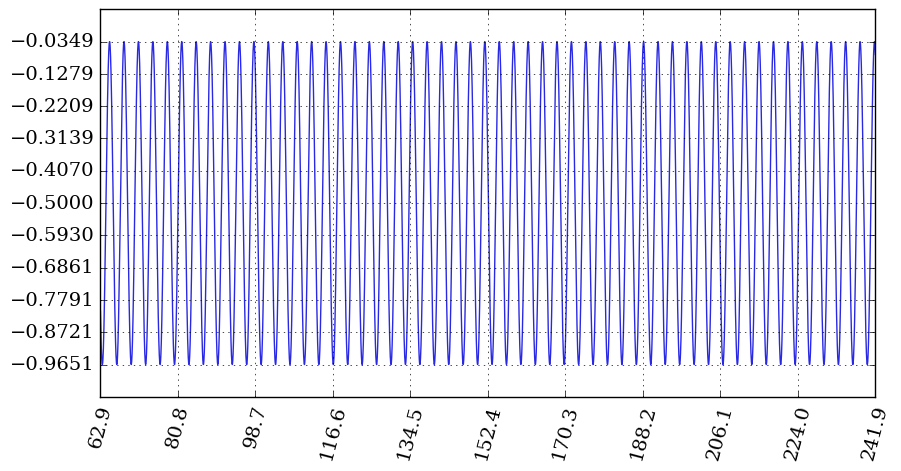

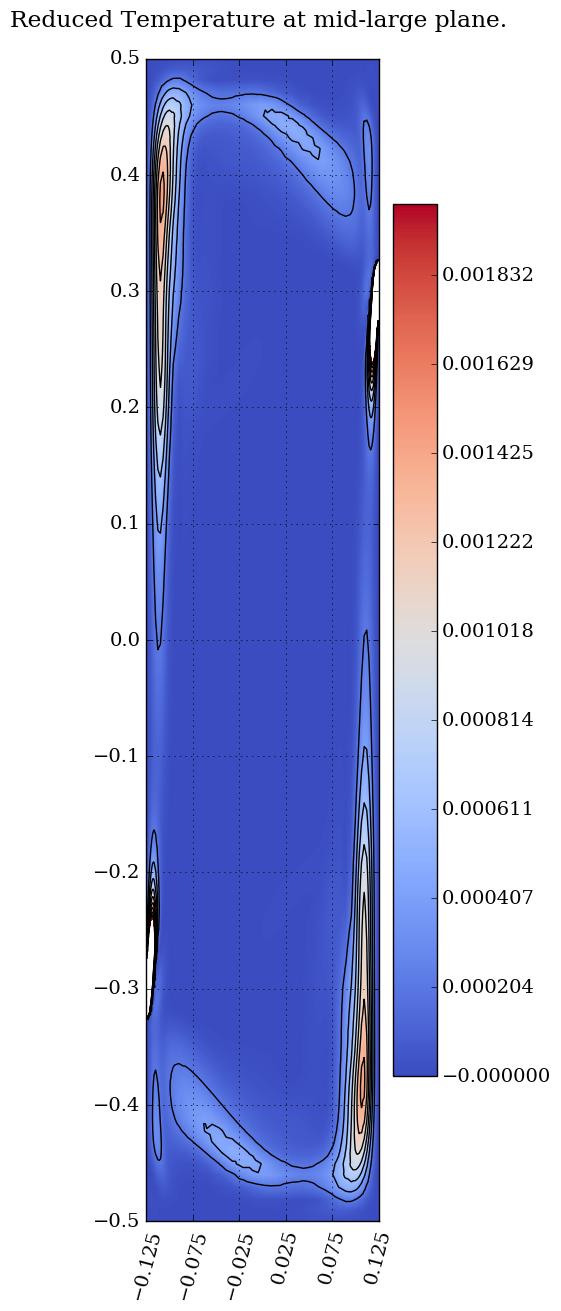

In [136]:
#data,mp_data = main()
data,mp_data,data_rms,data_avg = main();